In [1]:
import numpy as np
import os
import pandas as pd
import pprint
from joblib import Parallel, delayed
import time 

from rdkit import Chem
from rdkit.Chem.Descriptors import NumRadicalElectrons

In [2]:
params = Chem.SmilesParserParams()
params.removeHs = False

## Check how many species wanted to be spin other than spin 0
- also check that all species had a charge of 0

In [3]:
def get_inchi_key(smi=''):
    mol = Chem.MolFromSmiles(smi, params)
    return Chem.MolToInchiKey(mol)

In [4]:
df = pd.read_csv('wb97xd3_cleaned.csv')
df

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...,74.207878,25.357506
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656627,12.050720
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,76.830279,22.023014
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]([C...,72.185427,-4.896952
...,...,...,...,...,...
11956,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2][C:4]([O:5][C:6](=[O:7])[H:15])([H:...,76.498542,71.925276
11957,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]1([H:11])[O:3][C@:6]([O:7][H:12])...,43.743167,6.397510
11958,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]([O:3][H:12])([C:4](=[O:5])[H:14]...,73.601660,27.552744
11959,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,66.621537,13.289960


******************************************************************************************
rxn000412
charge: 1
[C:1](=[N+:2]1[C:3]([H:7])([H:10])[N:4][N:5]=[N:6]1)([H:8])[H:9]


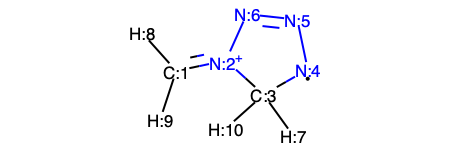

p000412 had charge of 1
******************************************************************************************
rxn001756
charge: 1
[C:1]([N:2][N:3]=[C:4]([N+:5]#[N:6])[H:10])([H:7])([H:8])[H:9]


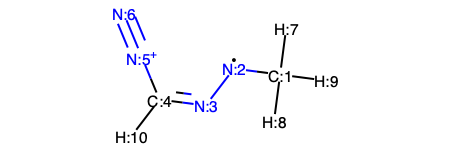

p001756 had charge of 1
******************************************************************************************
rxn002659
charge: 1
[C:1](=[N+:2]1[C:3]([H:8])([H:10])[N:4][N:5]=[C:6]1[H:11])([H:7])[H:9]


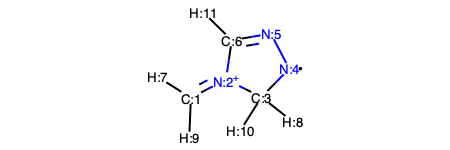

p002659 had charge of 1
******************************************************************************************
rxn004005
charge: 1
[O:1](/[C:2](=[N:3]\[N:4][H:8])[N+:6]#[N:5])[H:7]


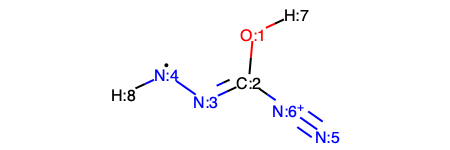

p004005 had charge of 1
******************************************************************************************
rxn004615
charge: 1
[N+:1]([C:2]1=[C:3]([H:9])[N:4]=[N:5][N:6]1)([H:7])([H:8])[H:10]


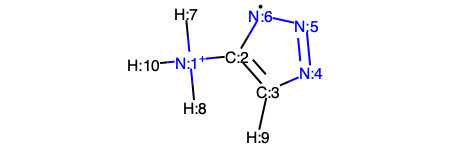

p004615 had charge of 1
******************************************************************************************
rxn007763
charge: 1
[O:1]=[C:2]([N:3][N:7]=[C:6]([N+:5]#[C:4][H:9])[H:10])[H:8]


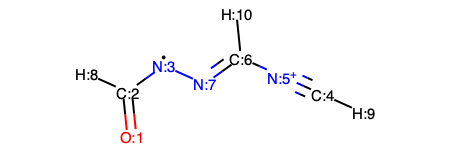

p007763 had charge of 1
0 reactants wanted to be spin 2
1521 products wanted to be spin 2
{'CH2': 61, 'CNH': 48}
0 reactants wanted to be spin 1
6 products wanted to be spin 1


In [5]:
# since the reactant and TS were calculated in the singlet state, each product must be in the singlet state
# alternatively, both products can be spin 1 (opposite spins that give a net spin of 0)
    
reactants_w_spin1 = []
products_w_spin1 = []
    
reactants_w_spin2 = []
products_w_spin2 = {}

products = {'CH2': 0,
            'CNH': 0,
           }
for idx, rsmi, psmiles in zip(df.idx.values, df.rsmi.values, df.psmi.values):
    r_mol = Chem.MolFromSmiles(rsmi, params)
    spin = NumRadicalElectrons(r_mol)  
    assert Chem.GetFormalCharge(r_mol) == 0
    
    if spin == 2:
        print(f'idx: {idx}')
        print(rsmi)
        display(r_mol)
        reactants_w_spin2.append(rsmi)
    elif spin == 1:
        reactants_w_spin1.append(idx)
    
    for psmi in psmiles.split('.'): 
        p_mol = Chem.MolFromSmiles(psmi, params)
        spin = NumRadicalElectrons(p_mol)
        if spin == 2:
            inchi_key = get_inchi_key(psmi)
            if inchi_key in products_w_spin2.keys():
                products_w_spin2[inchi_key].append(psmi)
            else:
                products_w_spin2.update({inchi_key: [psmi]})
            
            if len(p_mol.GetAtoms()) == 3:
                items = psmi.split(':')
                atoms = [items[0][-1], items[1][-1], items[2][-1]]
                if 'C' in atoms and 'N' in atoms and 'H' in atoms:
                    products['CNH'] += 1
                elif 'C' in atoms and 'H' in atoms:
                    # display(p_mol)
                    products['CH2'] += 1
        elif spin == 1:
            print('*'*90)
            print(f'rxn{idx:06}')
            charge = Chem.GetFormalCharge(p_mol)
            print(f'charge: {charge}')
            print(psmi)
            display(p_mol)
            products_w_spin1.append(idx)
        try:
            assert Chem.GetFormalCharge(p_mol) == 0
        except:
            print(f'p{idx:06} had charge of {Chem.GetFormalCharge(p_mol)}')

print(f'{len(reactants_w_spin2)} reactants wanted to be spin 2')
print(f'{len(products_w_spin2)} products wanted to be spin 2')
pprint.pprint(products)

print(f'{len(reactants_w_spin1)} reactants wanted to be spin 1')
print(f'{len(products_w_spin1)} products wanted to be spin 1')

### inspect some of the species that wanted to be spin 2

In [6]:
for key, value in products_w_spin2.items():
    if len(value) > 10:
        print(f'{key}: {len(value)}')
        print(f'\t {value[0]}')
        print(f'\t {value[1]}')

HZVOZRGWRWCICA-UHFFFAOYSA-N: 61
	 [C:1]([H:6])[H:7]
	 [C:2]([H:7])[H:8]
UUOIGPDTLYBNGY-UHFFFAOYSA-N: 52
	 [O:1]([C:2][H:8])[H:7]
	 [O:1]([C:2][H:8])[H:6]
QIUBLANJVAOHHY-UHFFFAOYSA-N: 48
	 [C:5]=[N:6][H:7]
	 [C:5]=[N:6][H:7]
UUFQTNFCRMXOAE-UHFFFAOYSA-N: 21
	 [C:4]([C:5]([H:14])([H:15])[H:16])[H:13]
	 [C:1]([C:2][H:9])([H:6])([H:7])[H:8]


# 6 products had a charge of 1 because the smiles were wrong. So fix those manually
The products with spin 1 also had charge 1. These smiles were previously interpretted incorrectly since they were missing an electron, causing the species to be positively charged (i.e. expected 32 valence electrons but there were only 31)


In [7]:
products_w_spin1

[412, 1756, 2659, 4005, 4615, 7763]

In [8]:
df_updated = df.copy(deep=True)

In [9]:
# all of these give the most representative resonance structure on https://rmg.mit.edu/molecule_search
proposed_smiles = [
    '[C:1](=[N+:2]1[C:3]([H:7])([H:10])[N:4]=[N:5][N-:6]1)([H:8])[H:9]',
    '[C:1]([N:2]=[N:3][C:4](=[N+:5]=[N-:6])[H:10])([H:7])([H:8])[H:9]',
    '[C:1](=[N+:2]1[C:3]([H:8])([H:10])[N-:4][N:5]=[C:6]1[H:11])([H:7])[H:9]',
    '[O:1]([C:2]([N:3]=[N:4][H:8])=[N+:6]=[N-:5])[H:7]',
    '[N+:1]([C:2]1=[C:3]([H:9])[N:4]=[N:5][N-:6]1)([H:7])([H:8])[H:10]',
    '[O:1]=[C:2]([N-:3][N:7]=[C:6]([N+:5]#[C:4][H:9])[H:10])[H:8]',
]

******************************************************************************************
412
[C:1](=[N+:2]1[C:3]([H:7])([H:10])[N:4][N:5]=[N:6]1)([H:8])[H:9]
charge: 1


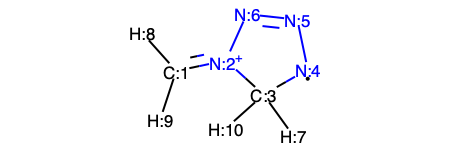

proposed smiles:
[C:1](=[N+:2]1[C:3]([H:7])([H:10])[N:4]=[N:5][N-:6]1)([H:8])[H:9]
charge: 0


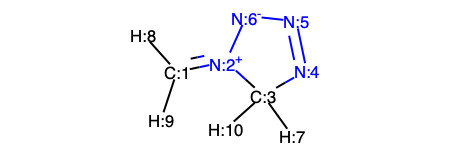

******************************************************************************************
1756
[C:1]([N:2][N:3]=[C:4]([N+:5]#[N:6])[H:10])([H:7])([H:8])[H:9]
charge: 1


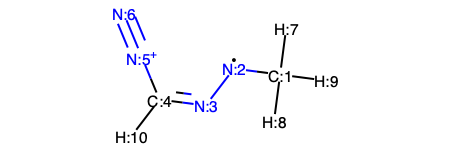

proposed smiles:
[C:1]([N:2]=[N:3][C:4](=[N+:5]=[N-:6])[H:10])([H:7])([H:8])[H:9]
charge: 0


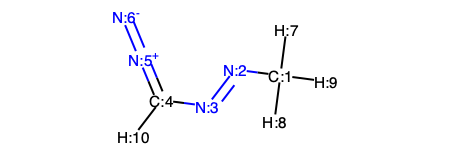

******************************************************************************************
2659
[C:1](=[N+:2]1[C:3]([H:8])([H:10])[N:4][N:5]=[C:6]1[H:11])([H:7])[H:9]
charge: 1


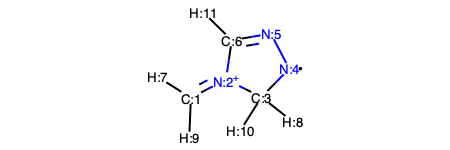

proposed smiles:
[C:1](=[N+:2]1[C:3]([H:8])([H:10])[N-:4][N:5]=[C:6]1[H:11])([H:7])[H:9]
charge: 0


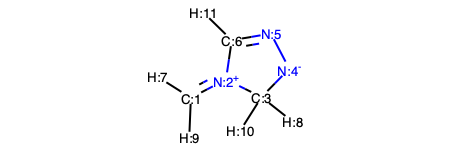

******************************************************************************************
4005
[O:1](/[C:2](=[N:3]\[N:4][H:8])[N+:6]#[N:5])[H:7]
charge: 1


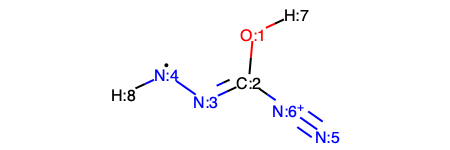

proposed smiles:
[O:1]([C:2]([N:3]=[N:4][H:8])=[N+:6]=[N-:5])[H:7]
charge: 0


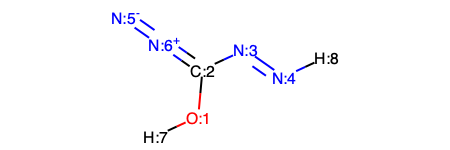

******************************************************************************************
4615
[N+:1]([C:2]1=[C:3]([H:9])[N:4]=[N:5][N:6]1)([H:7])([H:8])[H:10]
charge: 1


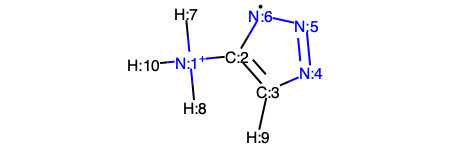

proposed smiles:
[N+:1]([C:2]1=[C:3]([H:9])[N:4]=[N:5][N-:6]1)([H:7])([H:8])[H:10]
charge: 0


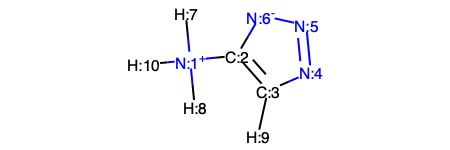

******************************************************************************************
7763
[O:1]=[C:2]([N:3][N:7]=[C:6]([N+:5]#[C:4][H:9])[H:10])[H:8]
charge: 1


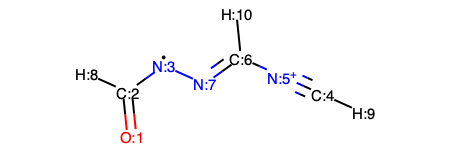

proposed smiles:
[O:1]=[C:2]([N-:3][N:7]=[C:6]([N+:5]#[C:4][H:9])[H:10])[H:8]
charge: 0


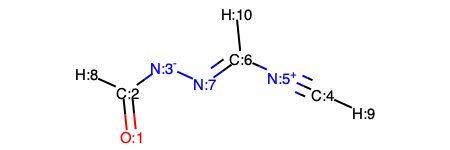

In [10]:
params = Chem.SmilesParserParams()
params.removeHs = False
for i, idx in enumerate(products_w_spin1):
    print('*'*90)
    for psmi in df[df.idx == idx].psmi.values[0].split('.'):
        print(idx)
        print(psmi)
        p_mol = Chem.MolFromSmiles(psmi, params)
        charge = Chem.GetFormalCharge(p_mol)
        print(f'charge: {charge}')
        display(p_mol)

        print('proposed smiles:')
        smi = proposed_smiles[i]
        print(smi)
        p_mol = Chem.MolFromSmiles(smi, params)
        charge = Chem.GetFormalCharge(p_mol)
        print(f'charge: {charge}')
        display(p_mol)
        
        df_updated[df_updated.psmi == psmi].psmi.values[0] = smi

# How many unique species do we have?

In [11]:
unique_r, unique_p = [], []

for i, row in df_updated.iterrows():
    inchi_key = get_inchi_key(row.rsmi)
    if inchi_key not in unique_r:
        unique_r.append(inchi_key)
    
    for psmi in row.psmi.split('.'):
        inchi_key = get_inchi_key(psmi)
        if inchi_key not in unique_p:
            unique_p.append(inchi_key)

In [12]:
len(unique_r)

1136

In [13]:
len(unique_p)

8885

In [14]:
# num unique reactants + num unique products + number of TSs
len(unique_r) + len(unique_p) + df.shape[0]

21982